In [1]:
import torch
import onnx
import onnxruntime as ort
import numpy as np

def load_pytorch_model(model_path):
    """Loads a PyTorch model from a given path."""
    model = torch.load(model_path, map_location="cpu",weights_only = False)
    model.eval()
    return model

def convert_to_onnx(model, onnx_path="model.onnx", input_shape=(1, 3, 224, 224)):
    """Converts a PyTorch model to ONNX."""
    dummy_input = torch.randn(*input_shape)
    torch.onnx.export(
        model, dummy_input, onnx_path, input_names=["input"], output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}, opset_version=12
    )
    print(f"✅ Model converted to ONNX: {onnx_path}")

def verify_onnx_model(onnx_path):
    """Verifies the integrity of an ONNX model."""
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)
    print("✅ ONNX model integrity verified!")

def run_onnx_inference(onnx_path, input_data):
    """Runs inference using ONNX Runtime."""
    session = ort.InferenceSession(onnx_path)
    outputs = session.run(None, {"input": input_data.numpy()})
    print("🔥 ONNX model inference successful!")
    return outputs

In [2]:
model = load_pytorch_model('./data/models/retrained_efficientnet_b0.pt')

In [3]:
convert_to_onnx(model)

✅ Model converted to ONNX: model.onnx


In [4]:
verify_onnx_model('./model.onnx')

✅ ONNX model integrity verified!


In [5]:
dummy_input = torch.randn(1, 3, 224, 224)
run_onnx_inference("model.onnx", dummy_input)

🔥 ONNX model inference successful!


[array([[-2.3873518 , -0.47520047, -1.5150976 , -1.0348022 ,  2.1694505 ,
         -3.4499354 ,  0.79535943,  1.6134588 , -1.2120458 , -1.7021166 ,
          1.9988552 , -2.6204362 , -1.2492561 ,  0.4046632 , -2.616104  ,
          0.39876306, -1.2176385 ,  0.07931751, -2.3534827 , -0.33681208,
         -0.61352086, -0.86405766, -1.6302767 ]], dtype=float32)]

In [104]:
from torchvision import transforms
from torch.nn.functional import softmax
import numpy as np
from PIL import Image
from transformers import AutoModelForImageClassification, AutoProcessor
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Define transformation
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #ImageNet Weights
])

img = Image.open('./sample_image.jpg').convert("RGB")
# inputs = my_transform(img)
img = my_transform(img).unsqueeze(0)

In [105]:
model_name = "vit-finetuned-dermnet"
model = AutoModelForImageClassification.from_pretrained(model_name)
model.eval()
processor = AutoProcessor.from_pretrained(model_name)

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

target_layers = [model.vit.encoder.layer[-1].layernorm_before]

# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(281)]

# input_tensor = processor(images=img, return_tensors="pt")

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers,  reshape_transform=reshape_transform) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=img, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

AttributeError: 'str' object has no attribute 'shape'

In [1]:
# output1 = model(img)
# probabilities = softmax(output1, dim=1)
# _, preds = probabilities.max(1)
# top5_prob, top5_indices = torch.topk(probabilities, 5)
# print(preds, top5_prob, top5_indices)

LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [51]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = torch.hub.load('facebookresearch/deit:main',
                           'deit_tiny_patch16_224', pretrained=True).to(device).eval()

Using cache found in C:\Users\Shankar/.cache\torch\hub\facebookresearch_deit_main


In [113]:
# model1

In [147]:
from torchvision import transforms
from torch.nn.functional import softmax
import numpy as np
from PIL import Image
from transformers import AutoModelForImageClassification, AutoProcessor
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch

""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits

# Define transformation
my_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #ImageNet Weights
])

rgb_img = Image.open('./sample_image.jpg').convert("RGB")
# inputs = my_transform(img)
img = my_transform(rgb_img).unsqueeze(0)


model_name = "vit-finetuned-dermnet"
model = AutoModelForImageClassification.from_pretrained(model_name)
model.eval()
processor = AutoProcessor.from_pretrained(model_name)


def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]

def reshape_transform_vit_huggingface(x):
    # Remove the CLS token:
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0], 14, 14, activations.shape[2])
    # Transpose the features to be in the second coordinate:
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

target_layer_dff = model.vit.layernorm
target_layer_gradcam = model.vit.encoder.layer[-2].output


# We have to specify the target we want to generate the CAM for.
targets = [ClassifierOutputTarget(category_name_to_index(model, '1'))]

# new_img = Image.fromarray(run_dff_on_image(model=model,
#                           target_layer=target_layer_dff,
#                           classifier=model.classifier,
#                           img_pil=rgb_img,
#                           img_tensor=img,
#                           reshape_transform=reshape_transform_vit_huggingface,
#                           n_components=4,
#                           top_k=2))

# input_tensor = processor(images=img, return_tensors="pt")

#Construct the CAM object once, and then re-use it on many images.
my_img=np.array(rgb_img.resize((224,224)))/255

with GradCAM(model=HuggingfaceToTensorModelWrapper(model), target_layers=[target_layer_dff, target_layer_gradcam],  reshape_transform=reshape_transform_vit_huggingface) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=img, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(my_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

In [116]:
name_to_index = dict((v, k) for k, v in model.config.id2label.items())
name_to_index

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '4': 24,
 '5': 25,
 '6': 26,
 '7': 27,
 '8': 28,
 '9': 29}

In [139]:
img.shape

torch.Size([1, 3, 472, 720])

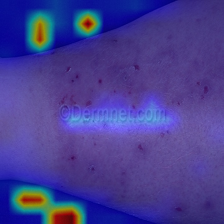

In [150]:
Image.fromarray(visualization)

In [184]:
org_image = Image.open('./data/training_data/train/0/07Acne081101.jpg').convert("RGB")
res = explain_image(org_image)

In [185]:
vis_image = base64.b64decode(res["xai_output"])
vis_image = Image.open(io.BytesIO(vis_image)).convert("RGB")